# PREDICTION DES RETARDS DE VOL


## 1. IMPORT DES LIBRAIRIES


In [1]:
import pandas as pd
from os.path import join
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## 2. CHARGEMENT DES DONNÉES


In [2]:
raw_data_path = join("..", "data", "raw")

In [3]:
complete_parquet_path = join(raw_data_path, "complete.parquet")

In [4]:
df = pd.read_parquet(complete_parquet_path)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5518860 entries, 0 to 5518859
Data columns (total 64 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   YEAR                   Int64 
 1   QUARTER                Int64 
 2   MONTH                  Int64 
 3   DAY_OF_MONTH           Int64 
 4   DAY_OF_WEEK            Int64 
 5   FL_DATE                object
 6   UNIQUE_CARRIER         object
 7   AIRLINE_ID             Int64 
 8   CARRIER                object
 9   TAIL_NUM               object
 10  FL_NUM                 Int64 
 11  ORIGIN_AIRPORT_ID      Int64 
 12  ORIGIN_AIRPORT_SEQ_ID  Int64 
 13  ORIGIN_CITY_MARKET_ID  Int64 
 14  ORIGIN                 object
 15  ORIGIN_CITY_NAME       object
 16  ORIGIN_STATE_ABR       object
 17  ORIGIN_STATE_FIPS      Int64 
 18  ORIGIN_STATE_NM        object
 19  ORIGIN_WAC             Int64 
 20  DEST_AIRPORT_ID        Int64 
 21  DEST_AIRPORT_SEQ_ID    Int64 
 22  DEST_CITY_MARKET_ID    Int64 
 23  DEST   

In [6]:
df.isna().sum()

YEAR                         1
QUARTER                      1
MONTH                        0
DAY_OF_MONTH                 1
DAY_OF_WEEK                  1
                        ...   
SECURITY_DELAY         4568715
LATE_AIRCRAFT_DELAY    4568715
FIRST_DEP_TIME         5485052
TOTAL_ADD_GTIME        5485052
LONGEST_ADD_GTIME      5485052
Length: 64, dtype: int64

In [7]:
missing_count = df[["DEP_TIME", "DEP_TIME_BLK"]].isnull().sum()

missing_percent = df[["DEP_TIME", "DEP_TIME_BLK"]].isnull().mean() * 100

print("Nombre de valeurs manquantes :")
print(missing_count)
print("\nPourcentage de valeurs manquantes :")
print(missing_percent)

Nombre de valeurs manquantes :
DEP_TIME        62841
DEP_TIME_BLK        2
dtype: int64

Pourcentage de valeurs manquantes :
DEP_TIME        1.138659
DEP_TIME_BLK    0.000036
dtype: float64


Nous constatons qu'il manque plus de `DEP_TIME` que de `DEP_TIME_BLK`. Nous décidons de remplacer les valeurs manquantes de `DEP_TIME` par la moyenne des `DEP_TIME` pour le même `DEP_TIME_BLK`.


In [8]:
df_retard = df[df["ARR_DEL15"] == 1]
df_ontime = df[df["ARR_DEL15"] == 0]

sample_size = 100000
n_per_class = int (sample_size / 2)

df_retard_sample = df_retard.sample(n=n_per_class, random_state=42)
df_ontime_sample = df_ontime.sample(n=n_per_class, random_state=42)

sample = (
    pd.concat([df_retard_sample, df_ontime_sample])
    .sample(frac=1, random_state=42)
    .reset_index(drop=True)
)

In [9]:
sample.to_parquet(join(raw_data_path, 'balanced_sample_100000.parquet'))

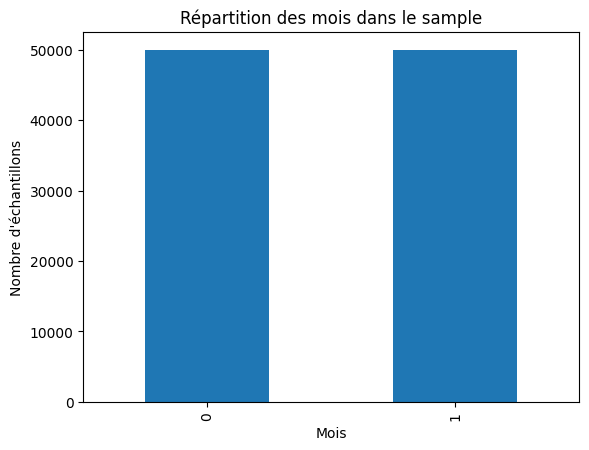

Moyenne des retards dans le sample complet: 0.50%


In [10]:
sample["ARR_DEL15"].value_counts().sort_index().plot(kind="bar")
plt.xlabel("Mois")
plt.ylabel("Nombre d'échantillons")
plt.title("Répartition des mois dans le sample")
plt.show()

mean_del_sample = sample["ARR_DEL15"].mean()
print(f"Moyenne des retards dans le sample complet: {mean_del_sample:.2f}%")

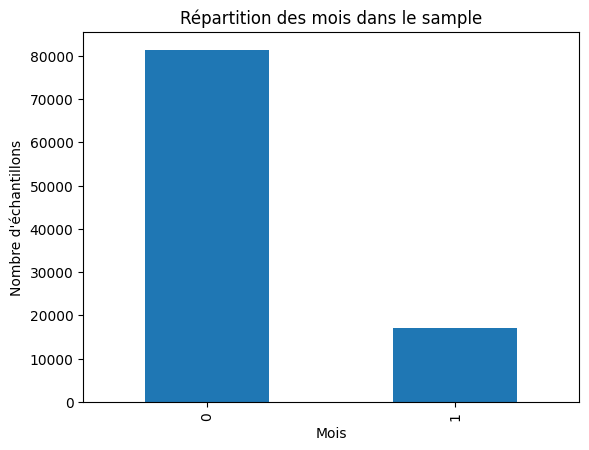

Moyenne des retards dans le sample: 0.17


In [13]:
sample["ARR_DEL15"].value_counts().sort_index().plot(kind="bar")
plt.xlabel("Mois")
plt.ylabel("Nombre d'échantillons")
plt.title("Répartition des mois dans le sample")
plt.show()

mean_del_sample = sample["ARR_DEL15"].mean()
print(f"Moyenne des retards dans le sample: {mean_del_sample:.2f}")

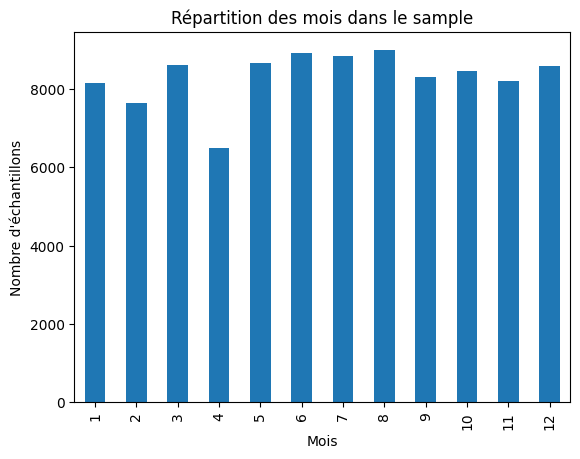

In [14]:
sample["MONTH"].value_counts().sort_index().plot(kind="bar")
plt.xlabel("Mois")
plt.ylabel("Nombre d'échantillons")
plt.title("Répartition des mois dans le sample")
plt.show()

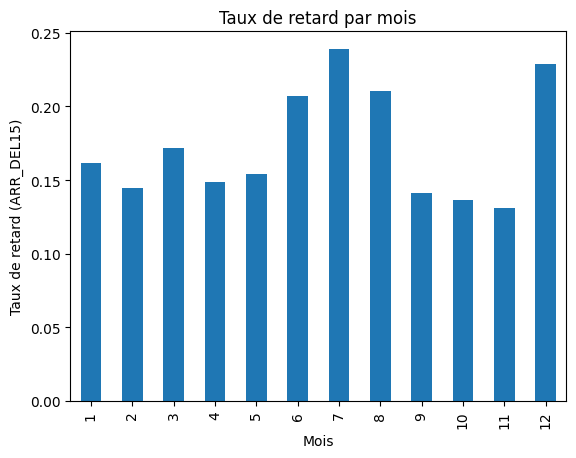

In [15]:
delay_by_month = sample.groupby("MONTH")["ARR_DEL15"].mean()

delay_by_month.plot(kind="bar")
plt.xlabel("Mois")
plt.ylabel("Taux de retard (ARR_DEL15)")
plt.title("Taux de retard par mois")
plt.show()

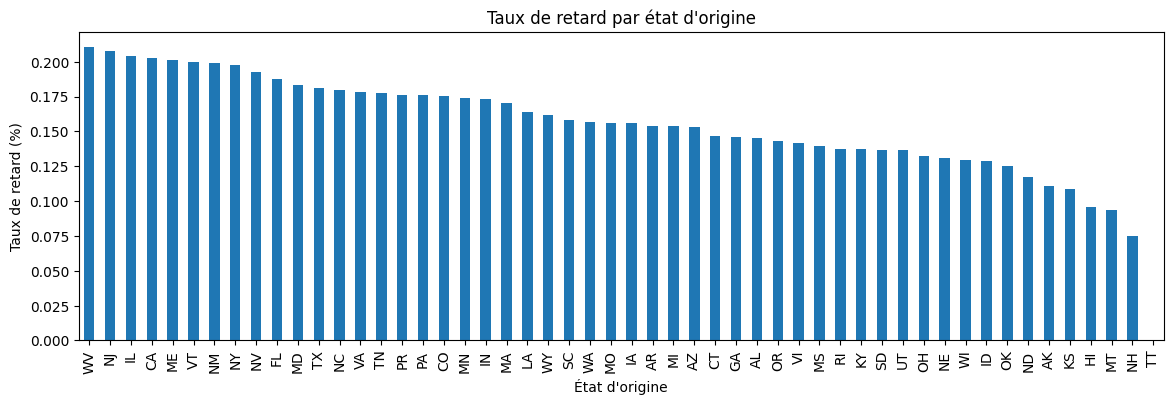

In [16]:
# Remplace 'ORIGIN_STATE_ABR' par le nom de ta colonne d'état si besoin
delay_by_state = (
    sample.groupby("ORIGIN_STATE_ABR")["ARR_DEL15"].mean().sort_values(ascending=False)
)

delay_by_state.plot(kind="bar", figsize=(14, 4))
plt.xlabel("État d'origine")
plt.ylabel("Taux de retard (%)")
plt.title("Taux de retard par état d'origine")
plt.show()

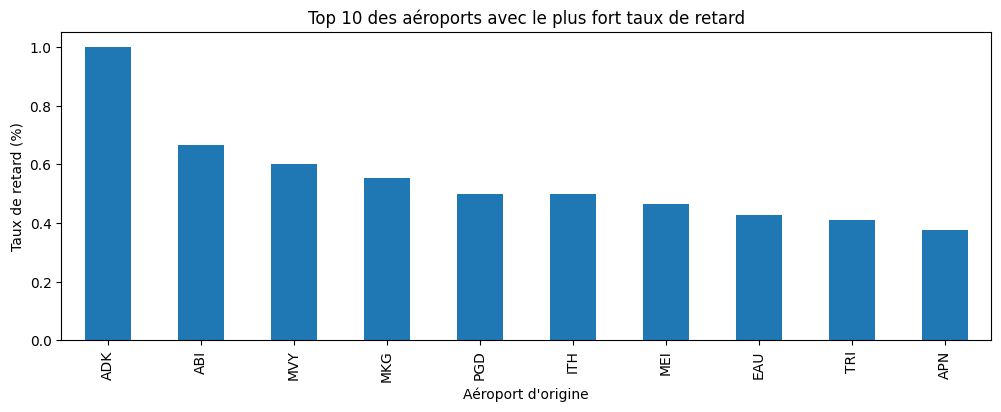

In [17]:
# Calcule le taux de retard par aéroport d'origine
delay_by_airport = (
    sample.groupby("ORIGIN")["ARR_DEL15"].mean().sort_values(ascending=False)
)

# Affiche les 10 aéroports avec le plus fort taux de retard
delay_by_airport.head(10).plot(kind="bar", figsize=(12, 4))
plt.xlabel("Aéroport d'origine")
plt.ylabel("Taux de retard (%)")
plt.title("Top 10 des aéroports avec le plus fort taux de retard")
plt.show()

## 3. EXPLORATION DES DONNÉES


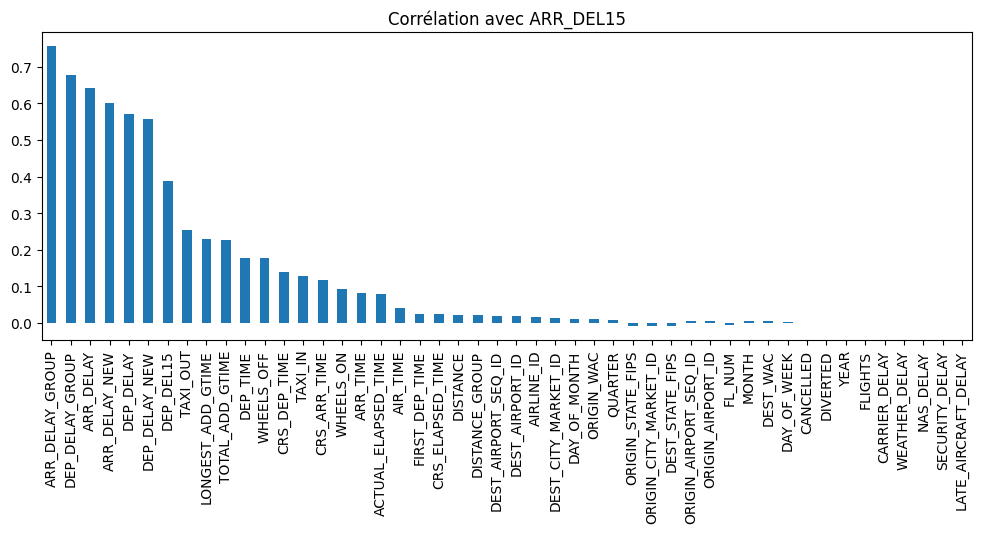

In [18]:
import matplotlib.pyplot as plt

corr_matrix = sample.corr(numeric_only=True)
corr_target = (
    corr_matrix["ARR_DEL15"].drop("ARR_DEL15").sort_values(key=abs, ascending=False)
)

corr_target.plot(kind="bar", figsize=(12, 4), title="Corrélation avec ARR_DEL15")
plt.show()
# ...existing code...

## 4. VISUALISATIONS


## 5.MODÉLISATION


In [19]:
cols_to_keep = [
    "MONTH",
    "DAY_OF_MONTH",
    "DAY_OF_WEEK",
    "UNIQUE_CARRIER",
    "TAIL_NUM",
    "FL_NUM",
    "ORIGIN",
    "DEST",
    "CRS_DEP_TIME",
    "CRS_ARR_TIME",
    "CRS_ELAPSED_TIME",
    "DISTANCE",
    "ARR_DEL15",
]

In [20]:
sample_clean = sample[cols_to_keep]
sample_clean = sample_clean.dropna(subset=["ARR_DEL15"])
sample_clean.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,TAIL_NUM,FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,CRS_ARR_TIME,CRS_ELAPSED_TIME,DISTANCE,ARR_DEL15
2088909,5,21,6,AA,N3FAAA,1155,BOS,ORD,530,719,169,867,0
2069434,5,7,6,UA,N69824,1634,ORD,ATL,909,1209,120,606,0
1329999,3,15,2,B6,N562JB,1206,PDX,JFK,2130,535,305,2454,0
2218336,6,13,1,DL,N592NW,1574,MCO,MSP,800,1027,207,1310,0
1805025,5,6,5,EV,N23139,4180,IAH,MCI,713,917,124,643,0


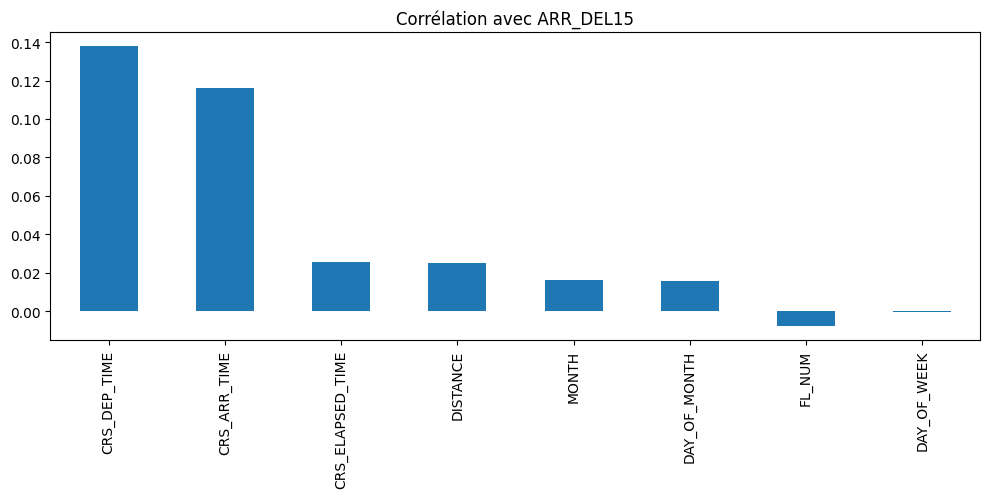

In [21]:
import matplotlib.pyplot as plt

corr_matrix = sample_clean.corr(numeric_only=True)
corr_target = (
    corr_matrix["ARR_DEL15"].drop("ARR_DEL15").sort_values(key=abs, ascending=False)
)

corr_target.plot(kind="bar", figsize=(12, 4), title="Corrélation avec ARR_DEL15")
plt.show()

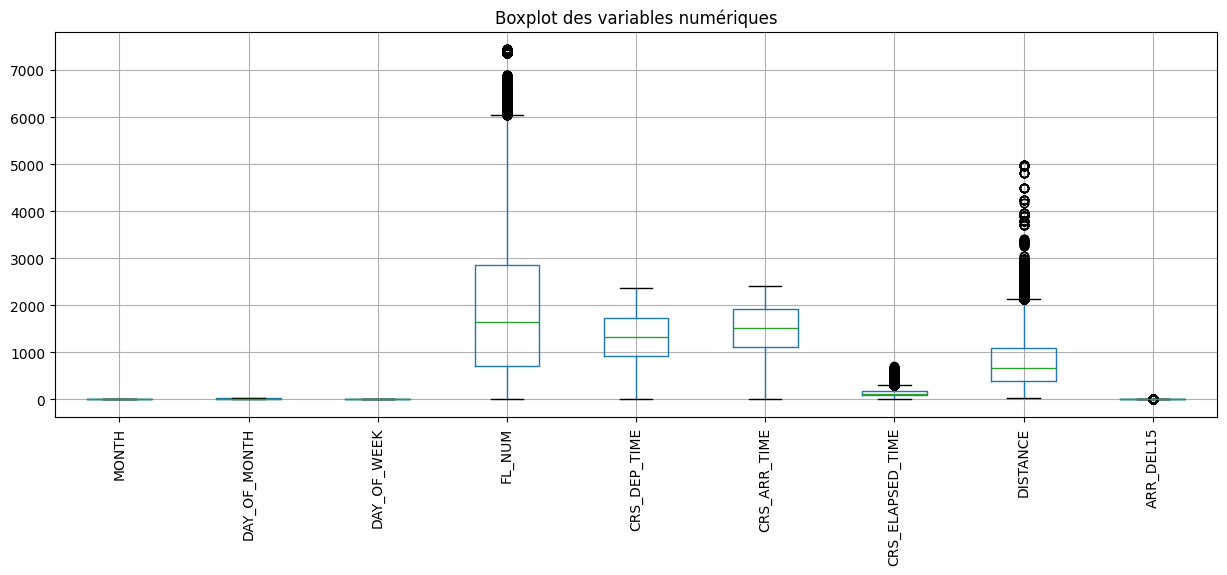

In [22]:
import matplotlib.pyplot as plt

sample_clean.boxplot(figsize=(15, 5), rot=90)
plt.title("Boxplot des variables numériques")
plt.show()